In [1]:
import warnings
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("../data/high_dataset.csv")


In [5]:
train_df , test_df = train_test_split (
        data , 
        test_size = 0.2 , 
        random_state = 42 , 
        stratify = data["label"] 
    )

In [6]:
class_counts  = train_df["label"].value_counts()

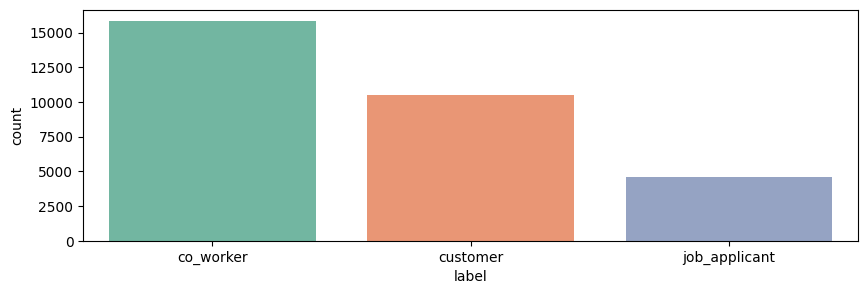

In [7]:
plt.figure(figsize = (10 , 3 ) )
sns.countplot( data = train_df ,  x = "label" , order = class_counts.index , palette = "Set2")
plt.show()

In [8]:
import re

def tokenizer(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r',' , ' ' , text)
    text = re.sub(r'\.' , ' ' , text ) 
    text = re.sub(r'-' , ' ' , text ) 
    return text


In [9]:
train_df["clean_text"] = train_df["text"].apply(tokenizer)

In [10]:
label_mapping = {
    "customer" : 0 , 
    "co_worker" : 1 ,
    "job_applicant" : 2
}

train_df["label_encoding"] = train_df["label"].map(label_mapping)

In [11]:
test_df["clean_text"] = test_df["text"].apply(tokenizer)
test_df["label_encoding"]  = test_df["label"].map(label_mapping)

In [12]:
test_df

,text,label,clean_text,label_encoding
19015,"Hi Team,\n\nJust confirming everyone's availab...",co_worker,hi team just confirming everyone's availabil...,1
27371,I'm having an issue with the {product_purchase...,customer,i'm having an issue with the {product_purchase...,0
3004,Congratulations to Bob for successfully comple...,co_worker,congratulations to bob for successfully comple...,1
32031,I'm having an issue with the {product_purchase...,customer,i'm having an issue with the {product_purchase...,0
19487,"Hi Riley,\n\nCan we schedule a quick meeting t...",co_worker,hi riley can we schedule a quick meeting to ...,1
...,...,...,...,...
6924,Update: The Sales team has finished the initia...,co_worker,update: the sales team has finished the initia...,1
33258,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant,dear hiring manager i am writing to express ...,2
4491,Join us for the Product Showcase on June 3. RS...,co_worker,join us for the product showcase on june 3 rs...,1
14939,Attached is the updated travel policy. All emp...,co_worker,attached is the updated travel policy all emp...,1


In [13]:
X = train_df["clean_text"]
y = train_df["label"]

In [14]:
X_train , X_test , y_train , y_test = train_test_split ( 
    X , 
    y , 
    test_size = 0.3 , 
    random_state = 42 ,
    stratify = y )

In [79]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 10 , 
    ngram_range = ( 1 , 2 ),
    stop_words = "english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])



In [80]:
from sklearn.naive_bayes import MultinomialNB


model = LogisticRegression(max_iter=1000 , verbose = 2)
model.fit(X_train_tfidf, y_train)
logistic_score = model.score(X_val_tfidf , y_test)

model_1 = MultinomialNB( )
model_1.fit(X_train_tfidf , y_train)
naive_score = model_1.score(X_val_tfidf , y_test)

print (f"LogisticRegression Score is {logistic_score * 100: .2f} %")
print()
print (f"naive bayes score        is {naive_score * 100: .2f} %") 

LogisticRegression Score is  84.25 %

naive bayes score        is  79.38 %


In [81]:
y_pred = model.predict(X_val_tfidf)


In [82]:
def predict(text):
    text = tokenizer(text)
    text_idf = tfidf_vectorizer.transform([text])
    return model.predict(text_idf)

In [83]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student a FSTM
    i want to express my interest for data science postion
"""
word_predicted = predict(text)[0]
print(f" the class predicted is   \"{word_predicted}\"")

 the class predicted is   "co_worker"


In [84]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student a FSTM
    i want to express my interest for data science postion
    project project project
"""
word_predicted = predict(text)[0]
print(f" the class predicted is   \"{word_predicted}\"")

 the class predicted is   "co_worker"


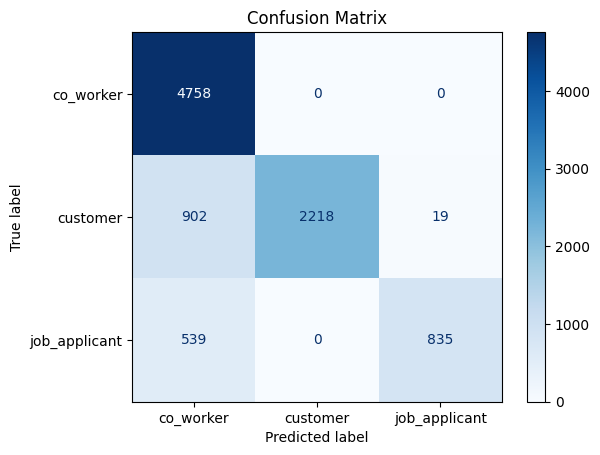

In [85]:
cm = confusion_matrix (y_test , y_pred , labels = model.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()



In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    co_worker       0.77      1.00      0.87      4758
     customer       1.00      0.71      0.83      3139
job_applicant       0.98      0.61      0.75      1374

     accuracy                           0.84      9271
    macro avg       0.92      0.77      0.82      9271
 weighted avg       0.88      0.84      0.84      9271



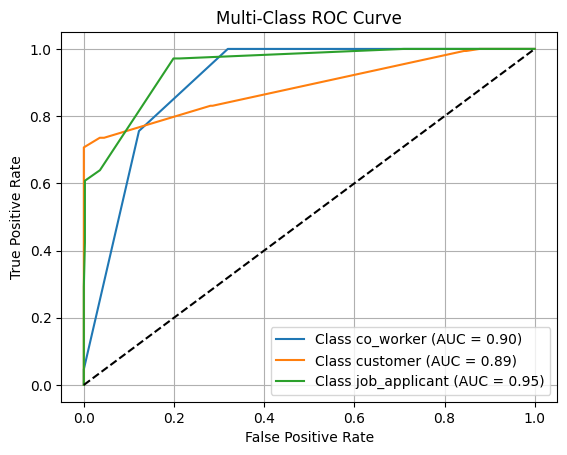

In [88]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

classes = model.classes_  
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_val_tfidf)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
